In [39]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
import numpy as np
import cv2
import os
import json
from zipfile import ZipFile

In [4]:
kaggle_credentials = json.load(open("kaggle.json"))

In [5]:
# setup Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentials["key"]

In [6]:
!kaggle datasets download -d andrewmvd/face-mask-detection

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection
License(s): CC0-1.0
 86% 341M/398M [00:00<00:00, 701MB/s]
100% 398M/398M [00:00<00:00, 585MB/s]


In [10]:
# Unzip the downloaded dataset
with ZipFile("face-mask-detection.zip", 'r') as zip_ref:
  zip_ref.extractall()

In [12]:
classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']
splits = ['train', 'val']

# Creating folders
for split in splits:
    for cls in classes:
        os.makedirs(f'data/{split}/{cls}', exist_ok=True)

print("✅ Folders created.")

✅ Folders created.


In [16]:
import xml.etree.ElementTree as ET
import random

# Set random seed for consistent train/val split
random.seed(42)

annotations_path = 'annotations'
images_path = 'images'

valid_classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']

In [17]:
# Pick one file to test
xml_file = 'maksssksksss0.xml'
xml_path = os.path.join(annotations_path, xml_file)

# Parse XML
tree = ET.parse(xml_path)
root = tree.getroot()

# Getting image name from XML
image_file = root.find('filename').text
image_path = os.path.join(images_path, image_file)

# Read the image
image = cv2.imread(image_path)
print("✅ Image loaded:", image_file)

✅ Image loaded: maksssksksss0.png


In [19]:
# Grab the first face object in the XML
face_obj = root.find('object')

# Get the class label (e.g., 'with_mask')
label = face_obj.find('name').text
print("Label:", label)

Label: without_mask


In [20]:
# Getting bounding box values
bbox = face_obj.find('bndbox')
xmin = int(bbox.find('xmin').text)
ymin = int(bbox.find('ymin').text)
xmax = int(bbox.find('xmax').text)
ymax = int(bbox.find('ymax').text)

print(f"Bounding box: ({xmin}, {ymin}) to ({xmax}, {ymax})")

Bounding box: (79, 105) to (109, 142)


In [21]:
# Cropping the face region from the image
face = image[ymin:ymax, xmin:xmax]

# Resize
face = cv2.resize(face, (128, 128))

print("Face cropped and resized.")

Face cropped and resized.


In [22]:
# Creating output folders
output_dir = "face_dataset"
classes = ["with_mask", "without_mask", "mask_weared_incorrect"]

for cls in classes:
    path = os.path.join(output_dir, cls)
    os.makedirs(path, exist_ok=True)

print("Class folders created in 'face_dataset/'")

Class folders created in 'face_dataset/'


In [24]:
save_path = os.path.join(output_dir, label, image_file)

# Save the cropped face
cv2.imwrite(save_path, face)

print(f"Face image saved to: {save_path}")

Face image saved to: face_dataset/without_mask/maksssksksss0.png


**Now: Loop Through the Entire Dataset**

In [28]:
# Paths
image_dir = "/content/images"
annotation_dir = "/content/annotations"
output_dir = "face_dataset"

# Classes to extract
classes = ["with_mask", "without_mask", "mask_weared_incorrect"]

# Loop through all annotation files
for xml_file in os.listdir(annotation_dir):
    if not xml_file.endswith(".xml"):
        continue

    xml_path = os.path.join(annotation_dir, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    image_file = root.find("filename").text
    image_path = os.path.join(image_dir, image_file)

    if not os.path.exists(image_path):
        continue

    image = cv2.imread(image_path)
    if image is None:
        continue

    # Looping through all objects (faces) in the image
    for obj in root.findall("object"):
        label = obj.find("name").text

        if label not in classes:
            continue

        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        # Crop and resize the face
        face = image[ymin:ymax, xmin:xmax]
        try:
            face = cv2.resize(face, (128, 128))
        except:
            continue  # skip this face if resizing fails

        # Saving cropped face with a unique filename
        save_name = f"{os.path.splitext(image_file)[0]}_{label}_{xmin}.png"
        save_path = os.path.join(output_dir, label, save_name)

        cv2.imwrite(save_path, face)

print("Dataset ready! All face images saved into class folders.")

Dataset ready! All face images saved into class folders.


In [29]:
import shutil

In [30]:
source_dir = "face_dataset"
target_dir = "data"
classes = ["with_mask", "without_mask", "mask_weared_incorrect"]

In [31]:
split_ratio = 0.8

for cls in classes:
    src_folder = os.path.join(source_dir, cls)
    images = os.listdir(src_folder)
    random.shuffle(images)

    split_idx = int(len(images) * split_ratio)
    train_imgs = images[:split_idx]
    val_imgs = images[split_idx:]

    # Move train images
    for img in train_imgs:
        src_path = os.path.join(src_folder, img)
        dest_path = os.path.join(target_dir, "train", cls, img)
        shutil.copy2(src_path, dest_path)

    # Move val images
    for img in val_imgs:
        src_path = os.path.join(src_folder, img)
        dest_path = os.path.join(target_dir, "val", cls, img)
        shutil.copy2(src_path, dest_path)

print("Dataset split complete!")

Dataset split complete!


**Will save the progress till now**

In [32]:
!zip -r data.zip data

  adding: data/ (stored 0%)
  adding: data/train/ (stored 0%)
  adding: data/train/with_mask/ (stored 0%)
  adding: data/train/with_mask/maksssksksss424_with_mask_312.png (deflated 17%)
  adding: data/train/with_mask/maksssksksss518_with_mask_258.png (deflated 15%)
  adding: data/train/with_mask/maksssksksss159_with_mask_5.png (deflated 4%)
  adding: data/train/with_mask/maksssksksss518_with_mask_107.png (deflated 15%)
  adding: data/train/with_mask/maksssksksss704_with_mask_49.png (deflated 3%)
  adding: data/train/with_mask/maksssksksss840_with_mask_223.png (deflated 6%)
  adding: data/train/with_mask/maksssksksss787_with_mask_247.png (deflated 5%)
  adding: data/train/with_mask/maksssksksss656_with_mask_26.png (deflated 8%)
  adding: data/train/with_mask/maksssksksss253_with_mask_209.png (deflated 4%)
  adding: data/train/with_mask/maksssksksss470_with_mask_344.png (deflated 6%)
  adding: data/train/with_mask/maksssksksss345_with_mask_186.png (deflated 6%)
  adding: data/train/with_

In [33]:
from google.colab import files
files.download("data.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Model Building**

In [34]:
from tensorflow.keras.applications import MobileNetV2

In [35]:
train_dir = "/content/data/train"
val_dir = "/content/data/val"

IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 10

In [36]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Validation data
val_datagen = ImageDataGenerator(rescale=1./255)

In [37]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 3221 images belonging to 3 classes.
Found 806 images belonging to 3 classes.


In [40]:
# MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(128, 128, 3)))
# Freeze the base model layers
base_model.trainable = False

/tmp/ipython-input-3240237743.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(128, 128, 3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [41]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)  # 3 classes

model = Model(inputs=base_model.input, outputs=predictions)

In [43]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [44]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


101/101 ━━━━━━━━━━━━━━━━━━━━ 37s 252ms/step - accuracy: 0.7784 - loss: 0.7965 - val_accuracy: 0.8610 - val_loss: 0.3747
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - accuracy: 0.8444 - loss: 0.4241 - val_accuracy: 0.8598 - val_loss: 0.3359
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - accuracy: 0.8565 - loss: 0.3753 - val_accuracy: 0.8859 - val_loss: 0.3043
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - accuracy: 0.8585 - loss: 0.3881 - val_accuracy: 0.8896 - val_loss: 0.3033
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - accuracy: 0.8626 - loss: 0.3660 - val_accuracy: 0.8908 - val_loss: 0.2942
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.8629 - loss: 0.3715 - val_accuracy: 0.8945 - val_loss: 0.2790
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.8648 - loss: 0.3711 - val_accuracy: 0.8834 - val_loss: 0.2844
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - accuracy: 0.8663 - loss: 0.3563 - val

**Visualize Accuracy and Loss**

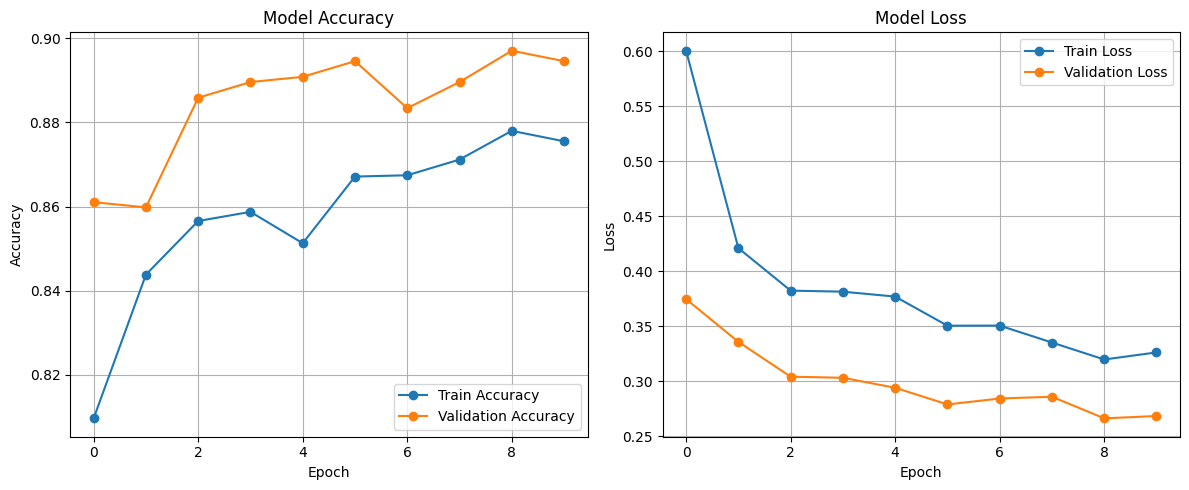

In [45]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Save the Model**

In [46]:
model.save("mask_detector.h5")

In [47]:
files.download("mask_detector.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>